In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
import os


In [2]:

# Setup
dataset_dir = r"C:/Users/arutj/OneDrive/Desktop/pro1/TrashType_Image_Dataset"
image_size = (224, 224)  # Increased resolution
batch_size = 32
seed = 42


In [3]:

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [5]:

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)


Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [6]:

# Split validation into val/test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Class names
class_names = train_ds.class_names

# Compute class weights
all_labels = []
for _, labels in train_ds:
    all_labels.extend(labels.numpy())
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)
class_weights = {i: w for i, w in enumerate(class_weights_array)}


In [7]:

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1)
])


In [8]:

# Load base model
base_model = EfficientNetV2B2(include_top=False, input_shape=(224, 224, 3),
                              include_preprocessing=True, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

# Build model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    layers.BatchNormalization(),
    GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])


In [9]:

# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [10]:

# Callbacks
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)


In [11]:

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr]
)



Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.2875 - loss: 2.1276 - val_accuracy: 0.5944 - val_loss: 1.3299 - learning_rate: 1.0000e-04
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.5450 - loss: 1.2584 - val_accuracy: 0.7269 - val_loss: 0.9518 - learning_rate: 1.0000e-04
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.6442 - loss: 0.9636 - val_accuracy: 0.7671 - val_loss: 0.6986 - learning_rate: 1.0000e-04
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7397 - loss: 0.7076 - val_accuracy: 0.8313 - val_loss: 0.5214 - learning_rate: 1.0000e-04
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7939 - loss: 0.5813 - val_accuracy: 0.8635 - val_loss: 0.3959 - learning_rate: 1.0000e-04
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.8202 - loss: 0.4855 - val_accuracy: 0.8755 - val_loss: 0.3645 - learning_rate: 1.0000e-04
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8414 

In [12]:

# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))


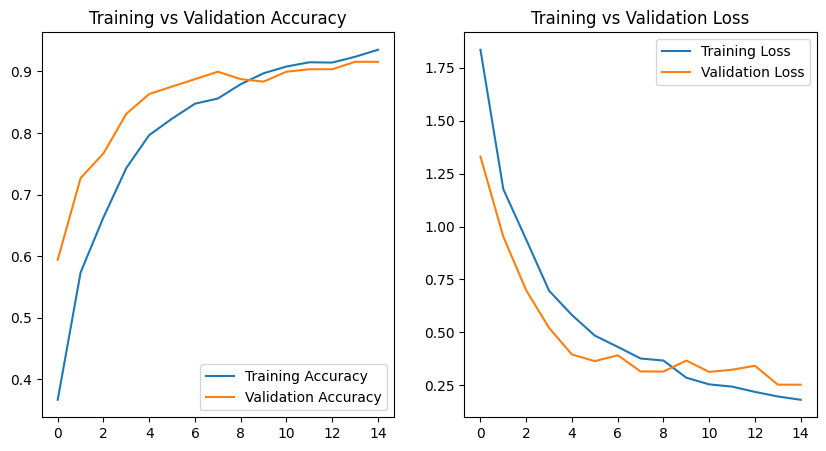

In [13]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [14]:

# Evaluate
loss, accuracy = model.evaluate(test_ds_eval)
print(f"Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.9383 - loss: 0.1878
Test Accuracy: 0.9375, Test Loss: 0.2052


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step
              precision    recall  f1-score   support

   cardboard       0.97      0.93      0.95        30
       glass       0.96      0.91      0.93        47
       metal       0.94      0.96      0.95        50
       paper       0.95      0.97      0.96        62
     plastic       0.95      0.91      0.93        45
       trash       0.80      0.91      0.85        22

    accuracy                           0.94       256
   macro avg       0.93      0.93      0.93       256
weighted avg       0.94      0.94      0.94       256



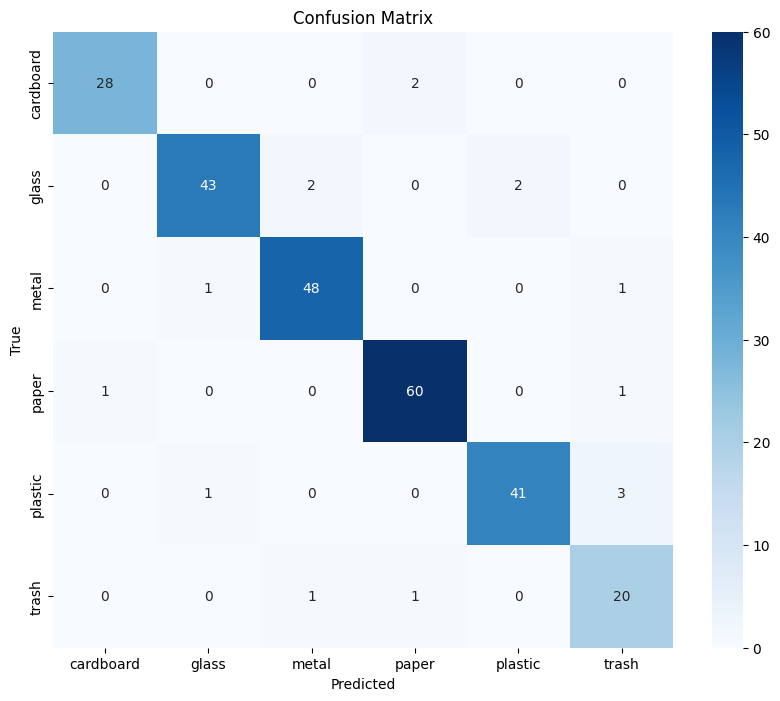

In [15]:

# Confusion matrix
y_true = np.concatenate([y.numpy() for _, y in test_ds_eval])
y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


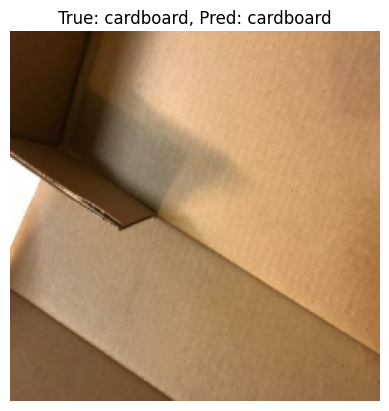

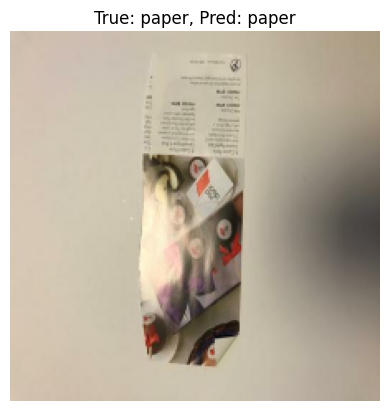

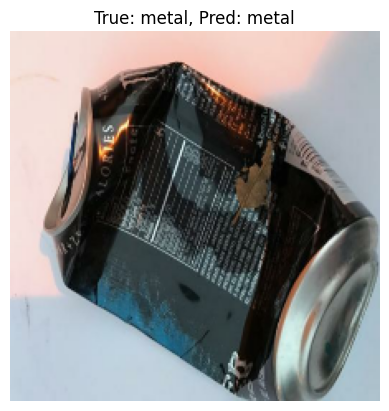

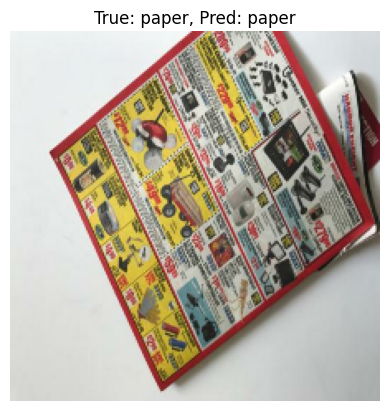

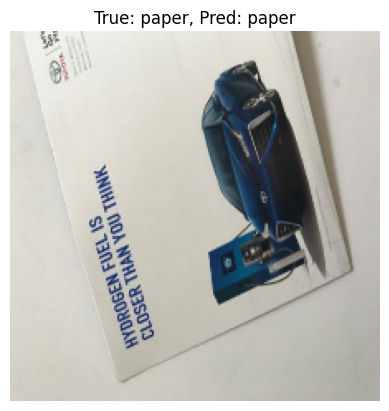

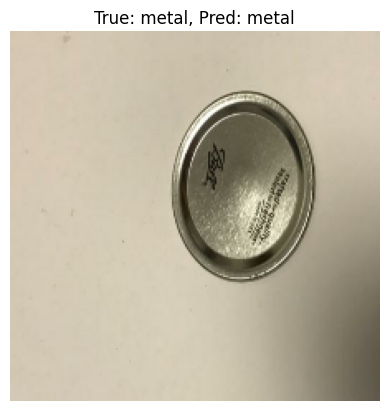

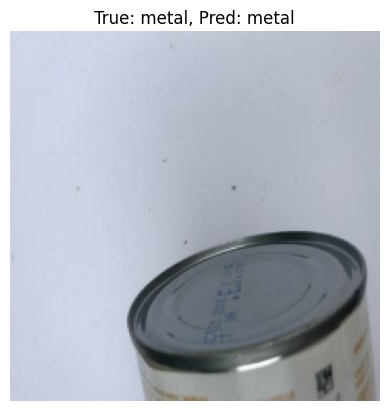

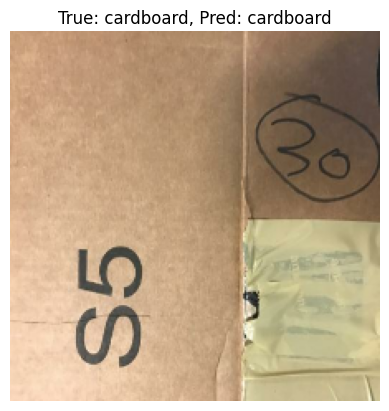

In [16]:

# Visualize predictions
for images, labels in test_ds_eval.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()


In [17]:

# Save model
model.save('EfficientNetV2B2_Optimized.keras')


In [ ]:

# Gradio Interface
def classify_image(img):
    img = img.resize((224, 224))
    img_array = np.array(img, dtype=np.float32)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_name = class_names[predicted_class]
    confidence = prediction[0][predicted_class]
    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

iface = gr.Interface(fn=classify_image, inputs=gr.Image(type="pil"), outputs="text")
iface.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
